In [1]:
import os
import time
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [4]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

new_sample_data = manager.list()
new_sample_labels = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect', 'sampler_loss_weight', 'all_labeled_mask']

# LOAD AND PREPROCESS DATA

In [5]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [7]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BULDING DATASET

In [8]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, data, labels, tokenizer, label2id, aspect_list, max_length=48):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = len(aspect_list)  # Total number of labels
        self.aspect_list = aspect_list
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.max_length = max_length
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        original_labels = torch.tensor([[self.label2id[label] for label in labels] for labels in self.gt_labels], dtype=torch.float32)
        encoded_labels = torch.tensor([[1 if label == 1 else 0 for label in labels] for labels in original_labels], dtype=torch.float32)
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * encoded_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx] 
        original_labels = torch.tensor([self.label2id[label] for label in self.gt_labels[idx]], dtype=torch.float32)
        encoded_labels = torch.tensor([1 if label == 1 else 0 for label in original_labels], dtype=torch.float32)

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)
        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample 

        inputs_list = [text_inputs, encoded_labels, idx, sampler_loss_weight, self.all_labeled_mask[idx], text, original_labels]
        return inputs_list

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, data, labels, aspects, indices, tokenizer, label2id, max_length):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = 2
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.aspects = aspects
        self.indices = indices
        self.max_length = max_length
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * self.gt_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.data[idx] 

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        if isinstance(self.gt_labels[idx], str):
            self.gt_labels[idx] = self.label2id[self.gt_labels[idx]]
        elif torch.is_tensor(self.gt_labels[idx]):
            self.gt_labels[idx] = int(self.gt_labels[idx].item())

        encoded_label = 1 if self.gt_labels[idx] == 2 else self.gt_labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)
        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample 
        original_label = torch.tensor(self.gt_labels[idx], dtype=torch.long)
        aspect = self.aspects[idx]

        inputs_list = [text_inputs, one_hot_label, idx, sampler_loss_weight, self.all_labeled_mask[idx], text, original_label, aspect, self.indices[idx]]
        return inputs_list

In [11]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, tokenizer, label_mapping, aspect_list, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, tokenizer, label_mapping, aspect_list, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [12]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    with torch.no_grad():
        for batch in train_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            
            outputs = aspect_detection_model(inputs_list)
            preds = torch.sigmoid(outputs[0]).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch[5][i])
                        train_labels.append(batch[6][i][j])
                        train_indices.append(batch[2][i])
            
        # Transform validation set
        for batch in val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            
            outputs = aspect_detection_model(inputs_list)
            preds = torch.sigmoid(outputs[0]).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch[5][i])
                        val_labels.append(batch[6][i][j])
                        val_indices.append(batch[2][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, tokenizer, label_mapping, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, tokenizer, label_mapping, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# DEFINE THE MODEL

In [13]:
class IndoBERT_Backbone(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Backbone, self).__init__()
        self.label_num = label_num
        self.encoder = IndoBERT_Encoder(label_num)
        model_config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
        self.clf = nn.Linear(model_config.hidden_size, label_num)
        nn.init.xavier_uniform_(self.clf.weight)

    def forward(self, inputs):
        encoder_out = self.encoder(inputs)
        out = self.clf(encoder_out)
        return out, encoder_out

class IndoBERT_Encoder(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Encoder, self).__init__()
        self.label_num = label_num
        self.encoder = BertModel.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=self.label_num,
        )
        
        self.encoder_init()

    def encoder_init(self):
        all_layers = ['embeddings', 'layer.0', 'layer.1', 'layer.2', 'layer.3', 'layer.4', 'layer.5', 'layer.6',
                      'layer.7', 'layer.8', 'layer.9', 'layer.10', 'layer.11', 'pooler']
        unfreeze_layers = all_layers[7:]
        for name, param in self.encoder.named_parameters():
            param.requires_grad = False
            for ele in unfreeze_layers:
                if ele in name:
                    param.requires_grad = True
                    break

    def forward(self, inputs):
        # Ensure each component in inputs is a tensor
        input_ids = torch.tensor(inputs[0]) if not isinstance(inputs[0], torch.Tensor) else inputs[0]
        token_type_ids = torch.tensor(inputs[1]) if not isinstance(inputs[1], torch.Tensor) else inputs[1]
        attention_mask = torch.tensor(inputs[2]) if not isinstance(inputs[2], torch.Tensor) else inputs[2]
        
        input_ids = input_ids.view(-1, input_ids.size(-1))  # Ensuring batch_size, sequence_length
        token_type_ids = token_type_ids.view(input_ids.size(0), -1)  # Reshaping to [batch_size, sequence_length]
        attention_mask = attention_mask.view(-1, attention_mask.size(-1))
        
        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        cls_output = outputs.pooler_output
        return cls_output

In [14]:
class MLP_VAE(nn.Module):
    def __init__(self, hidden_size, device, label_num):
        super(MLP_VAE, self).__init__()
        self.device = device
        self.label_num = label_num
        self.cl_neg_mode = 2
        self.proto_size = 64
        self.hidden_size = hidden_size
        
        # Initial fully connected layer to project input to higher-dimensional space for each label
        self.fc0 = nn.Linear(self.hidden_size, self.label_num * 512)
        self.fc1 = nn.Linear(512, self.proto_size)  # Dimensionality reduction for prototypes

        # Adjust the number of label representations based on contrastive learning mode
        if self.cl_neg_mode == 0:
            cl_label_num = self.label_num  # Standard label number
        elif self.cl_neg_mode == 1:
            cl_label_num = self.label_num + 1  # Add one for negative prototype handling
            self.ins_neg_cnt = torch.zeros(1).to(device)
        elif self.cl_neg_mode == 2:
            cl_label_num = self.label_num * 2  # Double for positive and negative prototypes
            self.ins_neg_cnt = torch.zeros(self.label_num).to(device)
        self.cl_label_num = cl_label_num

        # Register buffer for label prototypes, aligned with CoMAL's prototype-based sampling
        self.register_buffer("prototypes", torch.zeros(self.cl_label_num, self.proto_size))
        self.ins_pos_cnt = torch.zeros(self.label_num).to(device)  # Track count of positive instances

        # Decoder and final aggregation layers
        self.fc3 = nn.Linear(self.proto_size, 512)
        self.agg = nn.Linear(self.label_num * 512, self.hidden_size)
        self.clf = nn.Linear(self.hidden_size, self.label_num)  # Classification layer

    def get_protos(self):
        return self.prototypes  # Return the prototypes for external use

    def reparameterize(self, mu, logvar):
        # VAE reparameterization trick for latent space sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def reset_proto(self):
        # Reset prototype and count buffers
        self.ins_pos_cnt *= 0
        self.ins_neg_cnt *= 0
        self.prototypes *= 0

    def forward(self, x, labels=None, weights=None, reset_proto=False):
        if reset_proto:
            self.reset_proto()
        
        # Project input into sub-representations per label
        sub_rep_ori = self.fc0(x)
        sr_shape = sub_rep_ori.shape
        sub_rep_ori = sub_rep_ori.view(sr_shape[0], self.label_num, -1)  # Split per label

        # Further reduction to prototype size and decoding step
        sub_rep = self.fc1(sub_rep_ori)
        dec_sub_rep = self.fc3(sub_rep)

        dist_1 = None
        sub_rep_norm = F.normalize(sub_rep.data, dim=-1)  # Normalize for distance calculations

        if labels is not None and weights is not None:
            # Generate masks for positive and negative samples
            pos_mask = labels * weights
            neg_mask = (1 - labels) * weights
            pos_mask = pos_mask.unsqueeze(-1)
            neg_mask = neg_mask.unsqueeze(-1)

            # Update positive instance counts
            self.ins_pos_cnt += torch.sum(pos_mask.squeeze(-1), dim=0)

            # Update prototypes based on positive and negative samples
            feat = torch.sum(sub_rep_norm * pos_mask, dim=0)
            self.prototypes[:self.label_num] = self.prototypes[:self.label_num] * self.ins_pos_cnt.unsqueeze(-1) + feat

            # Handle different contrastive learning modes
            if self.cl_neg_mode == 2:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                self.ins_neg_cnt += torch.sum(neg_mask.squeeze(-1), dim=0)
                self.prototypes[self.label_num:] = self.prototypes[self.label_num:] * self.ins_neg_cnt.unsqueeze(-1) + feat_neg
            elif self.cl_neg_mode == 1:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                feat_neg = torch.sum(feat_neg, dim=0)
                self.ins_neg_cnt += torch.sum(neg_mask)
                self.prototypes[-1] = self.prototypes[-1] * self.ins_neg_cnt + feat_neg
            
            self.prototypes = F.normalize(self.prototypes, p=2, dim=-1)

        # Calculate distances between sub-representations and prototypes
        if self.cl_neg_mode == 2:
            dist_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[:self.label_num]])
            # print(dist_1[:3])
            dist_neg_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[self.label_num:]])
            dist_1 = torch.cat([dist_1, dist_neg_1], dim=1)  # Combine distances for positive and negative prototypes

        else:
            dist_1 = sub_rep_norm @ self.prototypes.T  

        # Decode and classify reconstructed input
        concat_sub_rep = dec_sub_rep.contiguous().view(dec_sub_rep.shape[0], -1)
        recon_x = self.agg(concat_sub_rep)
        recon_x_clf = self.clf(recon_x)

        return recon_x, sub_rep, recon_x_clf, dist_1  # Return reconstruction, sub-representation, classification, and distances

In [15]:
def get_cl_labels(labels, label_num, weight, cl_neg_mode=2):
    cl_labels = torch.zeros_like(labels, dtype=torch.long)
    cl_labels.fill_(label_num)
    example_idx, label_idx = torch.where(labels>=0.5)
    cl_labels[example_idx, label_idx] = label_idx #.float()
    cl_labels = cl_labels * weight + label_num * (1 - weight)
    if cl_neg_mode == 2:
        example_idx, label_idx = torch.where(labels < 0.5)
        cl_neg_labels = label_idx + label_num
        cl_labels[example_idx, label_idx] = cl_neg_labels.float()
        cl_labels = cl_labels * weight + 2 * label_num * (1 - weight)
    cl_labels = cl_labels.to(torch.int)
    return cl_labels

def get_cl_mask(cl_labels, label_num, batch_size, cl_neg_mode=2):
    mask = torch.eq(cl_labels[:batch_size], cl_labels.T).float()
    if cl_neg_mode == 0:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 1:
        neg_idx, _ = torch.where(cl_labels[:batch_size] > label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 2:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num * 2)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    else:
        neg_mask = torch.ones_like(mask)
    return mask, neg_mask

# DEFINE LOSSES

In [16]:
class SupConLoss(nn.Module):
    """Following Supervised Contrastive Learning:
        https://arxiv.org/pdf/2004.11362.pdf."""

    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, features, mask, neg_mask=None, batch_size=-1, device=None, other_features=None):
        if mask is not None:
            # SupCon loss (Partial Label Mode)
            mask = mask.float().detach()
            # compute logits
            if other_features is None:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], features.T),
                    self.temperature)
            else:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], other_features.T),
                    self.temperature)

            # for numerical stability
            logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
            logits = anchor_dot_contrast - logits_max.detach()

            # mask-out self-contrast cases
            if neg_mask is None:
                logits_mask = torch.ones_like(mask)
            else:
                logits_mask = torch.scatter(
                    neg_mask,
                    1,
                    torch.arange(batch_size).view(-1, 1).to(device),
                    0
                )
            mask = mask * logits_mask

            # compute log_prob
            exp_logits = torch.exp(logits) * logits_mask
            log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
            # compute mean of log-likelihood over positive
            mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
            # loss
            loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
            loss = loss.mean()
        else:
            q = features[:batch_size]
            k = features[batch_size:batch_size * 2]
            queue = features[batch_size * 2:]
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,kc->nk', [q, queue])
            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= self.temperature

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
            loss = F.cross_entropy(logits, labels)

        return loss

# MODEL TRAINING AND TESTING

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [18]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [20]:
def concat_test_result(outputs):
    outputs[0] = np.concatenate(outputs[0], axis=0)
    outputs[1] = np.concatenate(outputs[1], axis=0)
    outputs[2] = np.concatenate(outputs[2], axis=0)
    outputs[3] = np.concatenate(outputs[3], axis=0)
    outputs[4] = np.concatenate(outputs[4], axis=0)
    return outputs

def neaten_test_result(outputs, logits, labels, test_type):
    labels = labels.data.cpu().numpy()
    prob, pred = torch.topk(logits, 6 if test_type == 'aspect' else 2)
    prob = torch.sigmoid(prob).data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    logits = torch.sigmoid(logits).data.cpu().numpy()
    pred_labels = np.zeros(logits.shape)
    pred_labels[logits >= 0.5] = 1
    outputs[0].append(labels)
    outputs[1].append(pred)
    outputs[2].append(prob)
    outputs[3].append(logits)
    outputs[4].append(pred_labels)
    
    return outputs

In [21]:
def train_total_sep2(aspect_datasets, dataloaders, trials, aspect_metrics, sentiment_metrics, metrics, current_train_size, filename, label_num=-1, seed=42, total_patience=3):
    set_seed(seed)
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)
    
    tasks = ['aspect', 'sentiment']
    sentiment_val_loader = None

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    for task in tasks:
        accelerator.print("--------------------------------------------------")
        if task == 'sentiment':
            accelerator.print("SENTIMENT ANALYSIS")
        else:
            accelerator.print("ASPECT DETECTION")
            
        accelerator.wait_for_everyone()
        best_score = {
            'accuracy': 0,
            'f1_micro': 0,
            'f1_macro': 0
        }  # Track best score for first phase
        best_score2 = {
            'accuracy': 0,
            'f1_micro': 0,
            'f1_macro': 0
        }  # Track best score for second phase
        second_phase = False  # Control flag for switching between training phases
        total_patience_cnt = 0
        models = {}

        # Initialize backbone model for task learning
        label_num = 6 if task == 'aspect' else 2
        models['backbone'] = IndoBERT_Backbone(label_num)
        optim_backbone = torch.optim.AdamW(models['backbone'].parameters(), lr=2e-5, weight_decay=0.01)

        # Initialize VAE module if specified (aligns with CoMAL's contrastive and auxiliary module)
        models['vae_module'] = MLP_VAE(768, device, label_num=label_num)
        optim_module = torch.optim.AdamW(models['vae_module'].parameters(), lr=2e-5, weight_decay=0.01)

        if task == 'sentiment':
            best_aspect_model = IndoBERT_Backbone(6)
            best_aspect_model.load_state_dict(torch.load(f"{filename}-aspect-p1-backbone-{trials+1}-{percentage}.pth"))
            train_loader, val_loader, _, _ = build_sentiment_dataset(
                device, aspect_datasets['train'], aspect_datasets['val'], best_aspect_model, tokenizer, max_length=sequence_length
            )
            sentiment_val_loader = val_loader
            
        else:
            train_loader = dataloaders['labeled']
            val_loader = dataloaders['test']

        accelerator.wait_for_everyone()
        models['backbone'], models['vae_module'], train_loader, val_loader = accelerator.prepare(
            models['backbone'], models['vae_module'], train_loader, val_loader
        )

        # Loop over epochs
        for epoch in range(1, epochs+1):
            if second_phase:
                models['backbone'].eval()  # Backbone frozen in second phase
            else:
                models['backbone'].train()
            models['vae_module'].train()

            # Iterate over labeled data for training
            total_loss = 0
            for data in train_loader:
                # Zero the gradients for all optimizers
                optim_backbone.zero_grad()
                optim_module.zero_grad()

                # Prepare inputs and labels for training
                labels, idx, loss_weight = [x.to(device) for x in data[1:4]]
                input_ids, input_type_ids, input_mask = [x.to(device) for x in data[0]]
                inputs_list = [input_ids, input_type_ids, input_mask, None]

                loss = 0

                # Forward pass through backbone model
                clf_out, encoder_cls = models['backbone'](inputs_list)

                # VAE training logic (aligns with CoMAL's multi-label decoupling and contrastive learning)
                loss2 = 0
                module_cls = encoder_cls.detach()  # Detach to prevent gradient flow to backbone

                # Forward pass through VAE module
                recon_x, latent_rep, recon_x_clf, _ = models['vae_module'](module_cls, labels=labels, weights=loss_weight, reset_proto=True)

                # Compute contrastive loss if enabled (aligns with CoMAL's use of contrastive learning)
                cl_labels = get_cl_labels(labels, label_num, loss_weight).view(-1)
                cl_labels_total = cl_labels.unsqueeze(-1)
                proj_total = latent_rep.view(-1, latent_rep.shape[-1])
                proj_total = F.normalize(proj_total, dim=-1)  # Normalize latent representation
                batch_size = clf_out.shape[0] * label_num
                mask, neg_mask = get_cl_mask(cl_labels_total, label_num, batch_size)

                criterion_cl = SupConLoss()  # Supervised contrastive loss function
                cl_loss = criterion_cl(proj_total, mask, neg_mask, batch_size, device)
                loss2 += cl_loss  # Add contrastive loss

                # Compute reconstruction and classification loss
                criterion_mse = nn.MSELoss()
                recon_mse_loss = criterion_mse(recon_x, module_cls)
                criterion_bce = nn.BCEWithLogitsLoss()
                recon_bce_loss = criterion_bce(recon_x_clf, labels.float())
                
                loss2 += recon_mse_loss + recon_bce_loss
                
                # Compute classification loss for the backbone (first phase)
                if not second_phase:
                    criterion = nn.BCEWithLogitsLoss()
                    clf_loss = criterion(clf_out, labels.float())
                    loss += clf_loss  # Add classification loss to total loss

                # Add VAE loss to total loss
                loss += loss2
                # Backpropagation step
                accelerator.backward(loss)
                
                total_loss += loss

                # Update weights based on current phase
                if second_phase:
                    optim_module.step()
                else:
                    optim_module.step()
                    optim_backbone.step()

            # Scheduler step for learning rate adjustment
            # if second_phase:
            #     accelerator.print('in second')
            
            result = {}
            outputs_clf = [[], [], [], [], []]
            outputs_dual = [[], [], [], [], []]
            match task:
                case 'aspect':
                    with torch.no_grad():
                        for data in val_loader:
                            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
                            labels = data[1].to(device)
                            out = [input_ids, input_type_ids, input_mask, None]
                
                            clf_out, encoder_cls = models['backbone'](out)
                            outputs_clf = neaten_test_result(outputs_clf, clf_out, labels, task)

                            if 'vae_module' in models.keys():
                                _, _, recon_x_clf, _ = models['vae_module'](encoder_cls, reset_proto=False)
                                outputs_dual = neaten_test_result(outputs_dual, recon_x_clf, labels, task)

                    if second_phase:
                        outputs_dual = concat_test_result(outputs_dual)
                        preds = torch.tensor(outputs_dual[4], device=device)
                        labels = torch.tensor(outputs_dual[0], device=device)
                    else:
                        outputs_clf = concat_test_result(outputs_clf)
                        preds = torch.tensor(outputs_clf[4], device=device)
                        labels = torch.tensor(outputs_clf[0], device=device)

                    preds = accelerator.gather_for_metrics(preds)
                    labels = accelerator.gather_for_metrics(labels)
                        
                    result = compute_metrics(
                        type('EvalOutput', (object,), {'predictions': preds.cpu().numpy(), 'label_ids': labels.cpu().numpy()}),
                        None,
                        ['fuel', 'machine', 'others', 'part', 'price', 'service']
                    )
                case 'sentiment':
                    sentiment_val_outputs = []
                    with torch.no_grad():
                        for data in val_loader:
                            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
                            labels = data[1].to(device)
                            out = [input_ids, input_type_ids, input_mask, None]
                        
                            clf_out, encoder_cls = models['backbone'](out)
                            clf_out = torch.sigmoid(clf_out)
                        
                            if 'vae_module' in models.keys():
                                _, _, recon_x_clf, _ = models['vae_module'](encoder_cls, reset_proto=False)
                                recon_x_clf = torch.sigmoid(recon_x_clf)

                            for i in range(len(clf_out)):
                                val_output = {
                                    'label': data[1][i],
                                    'aspect': data[7][i],
                                    'ori_indices': data[2][i],
                                    'pred': np.argmax(clf_out[i].cpu().numpy() if not second_phase else recon_x_clf[i].cpu().numpy()),
                                }
                                sentiment_val_outputs.append(val_output)

                    sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
                    unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
                    sentiment_val_outputs = list(unique_val_outputs.values())

                    result = compute_metrics(
                        type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
                        [0, 1],
                        ['negative', 'positive']
                    )

            # if second_phase:
            #     if result["f1_micro"] >= best_score2['f1_micro']:
            #         total_patience_cnt = 0
            #         best_score2 = result
                    
            #         accelerator.wait_for_everyone()
            #         unwrapped_vae = accelerator.unwrap_model(models['vae_module'])
            #         if accelerator.is_local_main_process:
            #             accelerator.save(unwrapped_vae.state_dict(), f"{filename}-{task}-p2-vae-{trials+1}-{percentage}.pth")
            #     else:
            #         total_patience_cnt += 1
            #         if total_patience_cnt >= total_patience:
            #             break
            # else:
            if result["f1_micro"] >= best_score['f1_micro']:
                best_score = result

                accelerator.wait_for_everyone()
                unwrapped_backbone = accelerator.unwrap_model(models['backbone'])
                unwrapped_vae = accelerator.unwrap_model(models['vae_module'])
                
                if accelerator.is_local_main_process:
                    accelerator.save(unwrapped_backbone.state_dict(), f"{filename}-{task}-p1-backbone-{trials+1}-{percentage}.pth")
                    accelerator.save(unwrapped_vae.state_dict(), f"{filename}-{task}-p1-vae-{trials+1}-{percentage}.pth")
            # else:
            #     total_patience_cnt += 1
            #     if total_patience_cnt >= total_patience:
            #         total_patience_cnt = 0
            #         second_phase = True
                
            accelerator.print(f"EPOCH {epoch} | LOSS: {total_loss / len(dataloaders['labeled'])} | ACCURACY: {round(result['accuracy'], 4)} | F1 MACRO: {round(result['f1_macro'], 4)} | F1 MICRO: {round(result['f1_micro'], 4)}")

        if accelerator.is_local_main_process:
            if task == 'aspect':
                aspect_metrics[0].append(best_score['accuracy'])
                aspect_metrics[1].append(best_score['f1_micro'])
                aspect_metrics[2].append(best_score['f1_macro'])
            elif task == 'sentiment':
                sentiment_metrics[0].append(best_score['accuracy'])
                sentiment_metrics[1].append(best_score['f1_micro'])
                sentiment_metrics[2].append(best_score['f1_macro'])
        
        accelerator.print(f"{task}: ACCURACY {round(best_score['accuracy'], 4)} | F1 MACRO {round(best_score['f1_macro'], 4)} | F1 MICRO {round(best_score['f1_micro'], 4)}")
        accelerator.print(best_score['report'])

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []

    accelerator.wait_for_everyone()

    best_aspect_model = IndoBERT_Backbone(6)
    best_sentiment_model = IndoBERT_Backbone(2)

    best_aspect_model.load_state_dict(torch.load(f"{filename}-aspect-p1-backbone-{trials+1}-{percentage}.pth"))
    best_sentiment_model.load_state_dict(torch.load(f"{filename}-sentiment-p1-backbone-{trials+1}-{percentage}.pth"))

    best_aspect_model, best_sentiment_model, val_loader = accelerator.prepare(best_aspect_model, best_sentiment_model, dataloaders['test'])

    with torch.no_grad():
        for batch in val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            clf_out, encoder_cls = best_aspect_model(inputs_list)
            preds = torch.sigmoid(clf_out).round()

            aspect_indices.append(accelerator.gather(batch[2]))
            aspect_labels.append(accelerator.gather(batch[6]))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            input_ids, input_type_ids, input_mask = [x.to(device) for x in batch[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]
            clf_out, encoder_cls = best_sentiment_model(inputs_list)
            preds = torch.sigmoid(clf_out).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch[7][i],
                    'ori_indices': batch[8][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
            
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])

# QUERY STRATEGY

In [22]:
def query_samples(filename, dataset, labeled_set, unlabeled_indices, num_labels, trials, sampling_dur, new_sample_data, new_sample_labels,
                  label_cardinality=None, labeled_subset=None, save_path=None, cl_neg_mode=2, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device

    models = {}
    tasks = ['aspect', 'sentiment']
    
    current_train_size = len(dataset.get_labeled_set())

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    for task in tasks:
        backbone = IndoBERT_Backbone(6 if task == 'aspect' else 2)
        vae = MLP_VAE(768, device, 6 if task == 'aspect' else 2)
        backbone.load_state_dict(torch.load(f"{filename}-{task}-p1-backbone-{trials+1}-{percentage}.pth"))
        models[f'{task}_backbone'] = backbone
        
        if os.path.exists(f'/kaggle/working/{filename}-{task}-p2-vae-{trials+1}.pth'):
            vae.load_state_dict(torch.load(f"{filename}-{task}-p2-vae-{trials+1}-{percentage}.pth"))
        else:
            vae.load_state_dict(torch.load(f"{filename}-{task}-p1-vae-{trials+1}-{percentage}.pth"))
        models[f'{task}_vae_module'] = vae

    # Set all models to evaluation mode to freeze parameters during sampling
    for model_name in models.keys():
        models[model_name].to(device)
        models[model_name].eval()

    # Initialize lists to store outputs used for sampling calculations
    aspect_outputs = {}
    sentiment_outputs = {}
    
    labeled_distances = []
    labeled_ground_truths = []
    
    labeled_aspects = []
    labeled_labels = []
    labeled_indices = []
    labeled_texts = []

    unlabeled_aspects = []
    unlabeled_labels = []
    unlabeled_ori_indices = []
    unlabeled_texts = []

    # DataLoader for labeled data subset, sampled randomly
    labeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=False,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )

    start_time = time.time()

    # Process labeled data to extract features and distances for sampling criteria
    for batch in labeled_dataloader:
        text_inputs = batch[0]
        gt_label = batch[1]
        idx = batch[2]
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            predictions, encoded_cls = models['aspect_backbone']([input_ids, token_type_ids, attention_mask, None])

            for i in range(len(predictions)):
                indices = idx[i].item()
                for j in range(len(predictions[i])):
                    if int(predictions[i][j].round()) != 1:
                        labeled_aspects.append(aspect_list[j])
                        labeled_labels.append(gt_label[i][j])
                        labeled_texts.append(batch[5][i])
                        labeled_indices.append(indices)
                    
            _, sub_representation, _, vae_distance = models['aspect_vae_module'](encoded_cls)
            vae_distance = vae_distance.cpu().data
            labeled_distances.extend(vae_distance)

    # print(vae_distance[:10])

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)
    labeled_distances = torch.stack(labeled_distances)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        # Compute self-prototype distances based on CoMAL's contrastive learning mode
        if cl_neg_mode == 1:
            labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
            labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
            labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
            positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
        elif cl_neg_mode == 2:
            # Split distances into positive and negative based on contrastive learning mode
            positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
            positive_distances = positive_distances * labeled_ground_truths
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # DataLoader for unlabeled data to compute sampling scores
        unlabeled_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            shuffle=False,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(unlabeled_indices)))
        )
    
        # Process unlabeled data to get sampling scores
        for batch in unlabeled_dataloader:
            text_inputs = batch[0]
            labels = batch[1]
            idx = batch[2]
            loss_weight = batch[3]
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['aspect_backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                
                for i in range(len(predictions)):
                    indices = idx[i].item()
                    
                    if indices not in aspect_outputs.keys():
                        aspect_outputs[indices] = {}
                        
                    aspect_outputs[indices]['backbone_predictions'] = predictions[i]
                    aspect_outputs[indices]['loss_weight'] = loss_weight[i]
                    
                    # Collect non neutral aspect for sentiment analysis
                    for j in range(len(predictions[i])):
                        if int(torch.sigmoid(predictions[i][j]).round()) != 1:
                            unlabeled_aspects.append(aspect_list[j])
                            unlabeled_labels.append(labels[i][j])
                            unlabeled_texts.append(batch[5][i])
                            unlabeled_ori_indices.append(indices)
    
                # Get latent representations, reconstructions, and distances
                _, _, _, vae_distance = models['aspect_vae_module'](encoded_cls)

                for i in range(len(vae_distance)):
                    aspect_outputs[idx[i].item()]['backbone_distances'] = vae_distance[i].cpu().data

        # Convert lists to tensors for further computation
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in aspect_outputs.keys()])
        sample_weights = torch.stack([aspect_outputs[key]['loss_weight'] for key in aspect_outputs.keys()])
        distance_matrix = torch.stack([aspect_outputs[key]['backbone_distances'] for key in aspect_outputs.keys()])
    
        # Convert predictions to probability and adjust masks for scoring
        backbone_predictions = torch.stack([aspect_outputs[key]['backbone_predictions'] for key, val in aspect_outputs.items()])
        probability_predictions = torch.zeros_like(backbone_predictions) + backbone_predictions
        probability_predictions = torch.sigmoid(probability_predictions)
        unlabeled_mask = torch.ones_like(sample_weights)
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        
        if cl_neg_mode == 2:
            positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
        elif cl_neg_mode == 1:
            positive_prototype_distances = distance_matrix[:, :, :-1]
            positive_prototype_distances = positive_prototype_distances * torch.eye(num_labels)
            positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2

        # Create a mask for nonzero elements
        nonzero_mask = score_weight > 0
    
        # Sum only nonzero elements per row
        sum_nonzero = (score_weight * nonzero_mask).sum(dim=-1)
        
        # Count nonzero elements per row
        count_nonzero = nonzero_mask.sum(dim=-1)
        
        # Avoid division by zero (optional, but recommended)
        count_nonzero = count_nonzero.clamp(min=1)
        
        # Compute mean
        score_weight = sum_nonzero / count_nonzero
        adjusted_score = torch.pow(score_weight, 0.5) + torch.pow(cardinality_difference, 1 - 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_scores = torch.mean(final_scores, dim=-1).cpu().numpy()

        z = 0
        for key in aspect_outputs.keys():
            aspect_outputs[key]['score'] = average_scores[z]
            z += 1

    # -------- SENTIMENT ANALYSIS ---------
    accelerator.wait_for_everyone()
    labeled_sentiment_dataset = SentimentAnalysisDataset(labeled_texts, labeled_labels, labeled_aspects, labeled_indices, tokenizer, label_mapping, max_length=sequence_length)
    unlabeled_sentiment_dataset = SentimentAnalysisDataset(unlabeled_texts, unlabeled_labels, unlabeled_aspects, unlabeled_ori_indices, tokenizer, label_mapping, max_length=sequence_length)
    
    labeled_loader = torch.utils.data.DataLoader(
        labeled_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    labeled_ground_truths = []
    labeled_distances = []
    for batch in labeled_loader:
        text_inputs = batch[0]
        gt_label = batch[1]
        gt_label /= 2
        input_ids, token_type_ids, attention_mask = [x.to(device, non_blocking=True) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            predictions, encoded_cls = models['sentiment_backbone']([input_ids, token_type_ids, attention_mask, None])
                    
            _, sub_representation, _, vae_distance = models['sentiment_vae_module'](encoded_cls)
            labeled_distances.extend(vae_distance.cpu().data)

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)
    labeled_distances = torch.stack(labeled_distances)

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        if cl_neg_mode == 1:
            labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
            labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
            labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
            positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
        elif cl_neg_mode == 2:
            # Split distances into positive and negative based on contrastive learning mode
            positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
            positive_distances = positive_distances * labeled_ground_truths
    
        # Calculate max, min, and mean positive distances for uncertainty measurement
        max_positive_distances = torch.max(positive_distances, dim=0)[0]
        min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
        mean_positive_distances = (max_positive_distances + min_positive_distances) / 2
    
        # Process unlabeled data to get sampling scores
        for batch in unlabeled_loader:
            text_inputs = batch[0]
            idx = batch[8]
            loss_weight = batch[3]
            input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
    
            with torch.no_grad():
                # Get predictions and encoded representations
                predictions, encoded_cls = models['sentiment_backbone']([input_ids, token_type_ids, attention_mask, None])
                predictions = predictions.cpu().data
                    
                for i in range(len(predictions)):
                    indices = idx[i].item()
                    if indices not in sentiment_outputs.keys():
                        sentiment_outputs[indices] = {}
                        sentiment_outputs[idx[i].item()]['backbone_predictions'] = [predictions[i]]
                        sentiment_outputs[idx[i].item()]['loss_weight'] = [loss_weight[i]]
                    else:
                        sentiment_outputs[idx[i].item()]['backbone_predictions'].append(predictions[i])
                        sentiment_outputs[idx[i].item()]['loss_weight'].append(loss_weight[i])
    
                # Get latent representations, reconstructions, and distances
                _, _, _, vae_distance = models['sentiment_vae_module'](encoded_cls)

                for i in range(len(vae_distance)):
                    indices = idx[i].item()
                    if 'backbone_distances' not in sentiment_outputs[indices].keys():
                        sentiment_outputs[indices]['backbone_distances'] = [vae_distance[i].cpu().data]
                    else:
                        sentiment_outputs[indices]['backbone_distances'].append(vae_distance[i].cpu().data)

        # print(len(unlabeled_sentiment_dataset), length, len(sentiment_outputs))
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in sentiment_outputs.keys()])

        sample_weights = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['loss_weight']), dim=0).round() 
            for key in sentiment_outputs
        ])
        distance_matrix = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['backbone_distances']), dim=0)
            for key in sentiment_outputs
        ])
        backbone_predictions = torch.stack([
            torch.mean(torch.stack(sentiment_outputs[key]['backbone_predictions']), dim=0) 
            for key in sentiment_outputs
        ])
        
        # Convert predictions to probability and adjust masks for scoring
        probability_predictions = torch.zeros_like(backbone_predictions) + backbone_predictions
        probability_predictions = torch.sigmoid(probability_predictions)
        unlabeled_mask = torch.ones_like(sample_weights)
    
        # Calculate uncertainty metrics and part scores for sampling
        sample_weights = sample_weights.view(-1)
    
        # Mask predictions based on positive distances
        positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
        negative_distance_mask = ((probability_predictions < 0.5) * unlabeled_mask).float()

        if cl_neg_mode == 2:
            positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
        elif cl_neg_mode == 1:
            positive_prototype_distances = distance_matrix[:, :, :-1]
            positive_prototype_distances = positive_prototype_distances * torch.eye(2)
            positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)
    
        # Compute scores based on uncertainty and diversity metrics
        prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
        distance_count = torch.sum(prediction_mask, dim=-1)
        cardinality_difference = torch.abs(distance_count - label_cardinality)
        score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2
        score_weight_negative = negative_distance_mask * (negative_prototype_distances + 1) / 2
        score_weight = score_weight + score_weight_negative
        # Create a mask for nonzero elements
        nonzero_mask = score_weight > 0
    
        # Sum only nonzero elements per row
        sum_nonzero = (score_weight * nonzero_mask).sum(dim=-1)
        
        # Count nonzero elements per row
        count_nonzero = nonzero_mask.sum(dim=-1)
        
        # Avoid division by zero (optional, but recommended)
        count_nonzero = count_nonzero.clamp(min=1)
        
        # Compute mean
        score_weight = sum_nonzero / count_nonzero
        adjusted_score = torch.pow(score_weight, 0.5) + torch.pow(cardinality_difference, 1 - 0.5)
        final_scores = adjusted_score.unsqueeze(-1)
        average_sentiment_scores = torch.mean(final_scores, dim=-1).cpu().numpy()

        z = 0
        for key in sentiment_outputs.keys():
            aspect_outputs[key]['score'] = (average_sentiment_scores[z] + aspect_outputs[key]['score']) / 2
            z += 1

        scores = np.array([output['score'] for output in aspect_outputs.values()])

        ranked_indices = np.argsort(scores)
        ranked_indices = ranked_indices[::-1]
        sample_indices = torch.stack([torch.tensor(key, dtype=torch.long) for key in aspect_outputs.keys()])
        
        # Select top samples for annotation
        threshold = np.percentile(scores, 90)
        items_greater_than_threshold = scores[scores >= threshold]
        num_of_candidates = min(math.ceil(0.1 * len(scores)), len(items_greater_than_threshold))
    
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            selected_indices = ranked_indices[:max(n_samples, num_of_candidates)]
        else:
            selected_indices = ranked_indices[:nearest_cp - current_train_size]
            
            temp = dataset.get_labeled_set()
            temp.extend([unlabeled_indices[int(i)] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        for x in selected_indices:
            new_sample_data.append(unlabeled_indices[int(x)])
        new_sample_labels = None
        
        end_time = time.time()
        duration = end_time - start_time
    
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
        sampling_dur.append(duration)

def pred_part_stat(pred, threshold=0.0):
    part_1 = torch.where(pred >= threshold)[0]
    part_0 = torch.where(pred < threshold)[0]
    return part_0, part_1

# PLOT RESULT

In [23]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# MAIN LOOP

In [24]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_sample_data = manager.list()
    new_sample_labels = manager.list()
    filename = f'casa-comal-init-{init_size}'
    
    current_train_size = initial_train_size
    start_time = time.time()
    set_seed(seed)

    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    # Load label information and dataset
    label_num = 6
    _, _, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length)
    
    # Shuffle and initialize labeled and unlabeled sets
    indices = list(range(len(aspect_train_dataset)))
    random.shuffle(indices)
    labeled_set = indices[:initial_train_size]  # Random initial labeled set
    unlabeled_set = [x for x in indices if x not in labeled_set]  # Define the unlabeled set
    
    # Update dataset with initial labeled set
    aspect_train_dataset.update_data(labeled_set, init_time=True)
    
    # Prepare data loaders for labeled and test sets
    labeled_loader = DataLoader(
        aspect_train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )
    test_loader = DataLoader(
        aspect_val_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )

    models = {}

    while current_train_size < checkpoints[len(checkpoints) - 1]:
        dataloaders = {
            'labeled': labeled_loader,
            'test': test_loader
        }
        aspect_datasets = {
            'train': aspect_train_dataset,
            'val': aspect_val_dataset
        }
    
        # Train model
        train_args = (
            aspect_datasets,
            dataloaders, 
            i, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            current_train_size, 
            filename,
            label_num,
            seed
        )
        notebook_launcher(train_total_sep2, train_args, num_processes=2)
        
        query_set = list(set(unlabeled_set))
        # random.shuffle(query_set)
    
        # Query samples for next cycle, using appropriate selection strategy
        new_sample_data = manager.list()
        new_sample_labels = manager.list()
        sampling_args = (
            filename,
            aspect_train_dataset, 
            labeled_set,
            query_set, 
            label_num,
            i,
            sampling_dur,
            new_sample_data,
            new_sample_labels,
            aspect_train_dataset.get_label_Cardinality()
        )
        notebook_launcher(query_samples, sampling_args, num_processes=2)
        new_sample_data = list(new_sample_data)
        new_sample_labels = list(new_sample_labels)

        # print(len(new_sample_data))
        aspect_train_dataset.update_data(new_sample_data, None)
        labeled_set = aspect_train_dataset.get_labeled_set()
        unlabeled_set = [x for x in indices if x not in labeled_set]
    
        # Refresh data loader with new labeled set
        labeled_loader = DataLoader(
            aspect_train_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(labeled_set)))
        )
        
        # Update current train size
        current_train_size = len(labeled_set)
        print("New train size:", current_train_size)
    
    # DataLoader dictionary to be used for training and testing
    dataloaders = {
        'labeled': labeled_loader,
        'test': test_loader
    }
    
    # Train last iteration
    train_args = (
        aspect_datasets,
        dataloaders, 
        i, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        current_train_size, 
        filename,
        label_num,
        seed
    )
    notebook_launcher(train_total_sep2, train_args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
        
    # Log results
    end_time = time.time()
    duration = end_time - start_time

    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")

    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 5.840257167816162 | ACCURACY: 0.6213 | F1 MACRO: 0.6554 | F1 MICRO: 0.7436
EPOCH 2 | LOSS: 4.919863224029541 | ACCURACY: 0.7381 | F1 MACRO: 0.8264 | F1 MICRO: 0.8409
EPOCH 3 | LOSS: 5.073450088500977 | ACCURACY: 0.782 | F1 MACRO: 0.8672 | F1 MICRO: 0.8723
EPOCH 4 | LOSS: 4.617539405822754 | ACCURACY: 0.776 | F1 MACRO: 0.8645 | F1 MICRO: 0.8698
EPOCH 5 | LOSS: 4.502077102661133 | ACCURACY: 0.785 | F1 MACRO: 0.871 | F1 MICRO: 0.8755
EPOCH 6 | LOSS: 4.332825660705566 | ACCURACY: 0.7775 | F1 MACRO: 0.8654 | F1 MICRO: 0.8706
EPOCH 7 | LOSS: 4.310992240905762 | ACCURACY: 0.7812 | F1 MACRO: 0.8685 | F1 MICRO: 0.8731
EPOCH 8 | LOSS: 4.3411054611206055 | ACCURACY: 0.7894 | F1 MACRO: 0.874 | F1 MICRO: 0.8772
EPOCH 9 | LOSS: 4.692227363586426 | ACCURACY: 0.7842 | F1 MACRO: 0.8712 | F1 MICRO: 0.8744
EPOCH 10 | LOSS: 4.65374231338501 | ACCURACY: 0.7746 | F1 MACRO: 0.8622 | F1 MICRO: 0.8666
aspect: ACCURACY 0.7894 | F1 MACRO 0.874 | F1 MICRO 0.8772
              precision    recall  

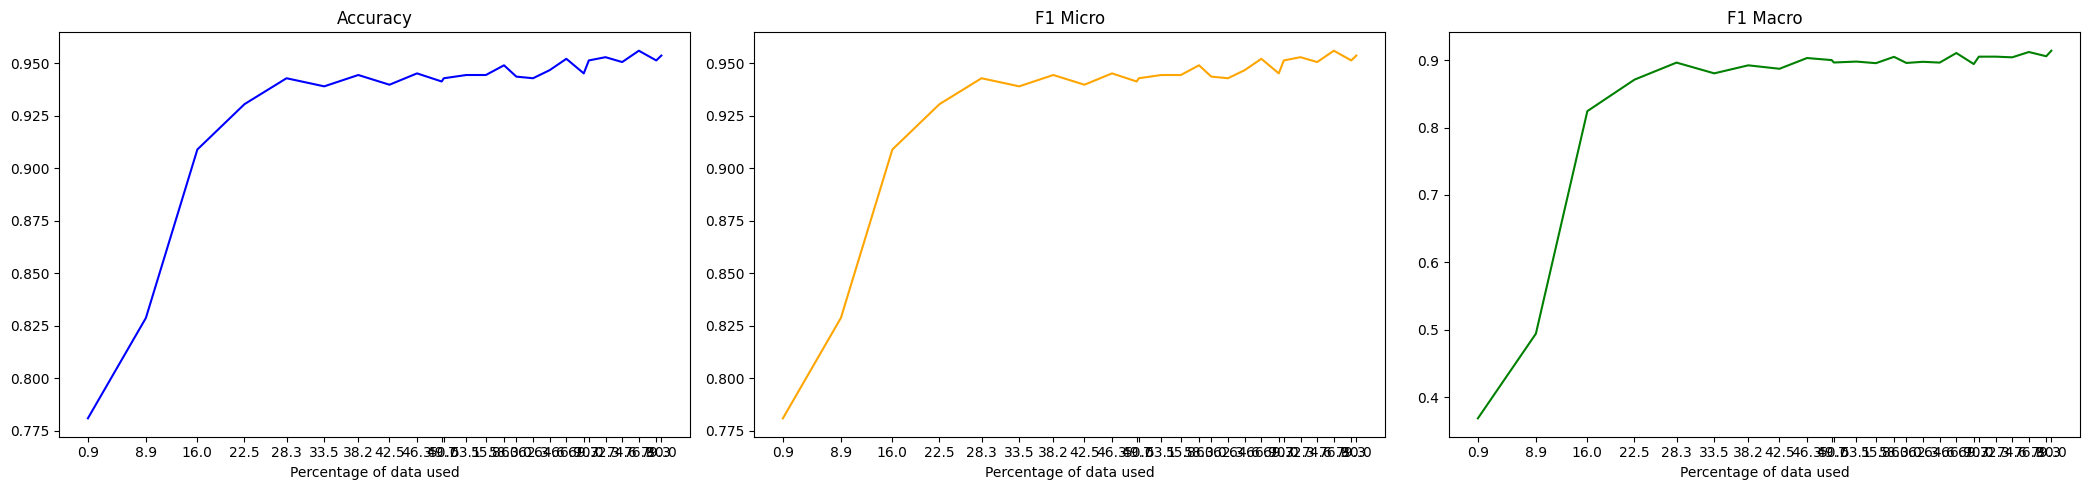

In [25]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU
--------------------------------------------------
ASPECT DETECTION
EPOCH 1 | LOSS: 2.890566349029541 | ACCURACY: 0.7321 | F1 MACRO: 0.7863 | F1 MICRO: 0.8375
EPOCH 2 | LOSS: 2.529599189758301 | ACCURACY: 0.7723 | F1 MACRO: 0.8634 | F1 MICRO: 0.8695
EPOCH 3 | LOSS: 2.411149024963379 | ACCURACY: 0.7917 | F1 MACRO: 0.881 | F1 MICRO: 0.8828
EPOCH 4 | LOSS: 2.3440663814544678 | ACCURACY: 0.7812 | F1 MACRO: 0.8716 | F1 MICRO: 0.8754
EPOCH 5 | LOSS: 2.292039155960083 | ACCURACY: 0.7589 | F1 MACRO: 0.8373 | F1 MICRO: 0.8571
EPOCH 6 | LOSS: 2.265507221221924 | ACCURACY: 0.7842 | F1 MACRO: 0.8643 | F1 MICRO: 0.8736
EPOCH 7 | LOSS: 2.2072181701660156 | ACCURACY: 0.8043 | F1 MACRO: 0.8798 | F1 MICRO: 0.8855
EPOCH 8 | LOSS: 2.1778054237365723 | ACCURACY: 0.8103 | F1 MACRO: 0.8824 | F1 MICRO: 0.8882
EPOCH 9 | LOSS: 2.1129932403564453 | ACCURACY: 0.8073 | F1 MACRO: 0.8759 | F1 MICRO: 0.8849
EPOCH 10 | LOSS: 2.078116

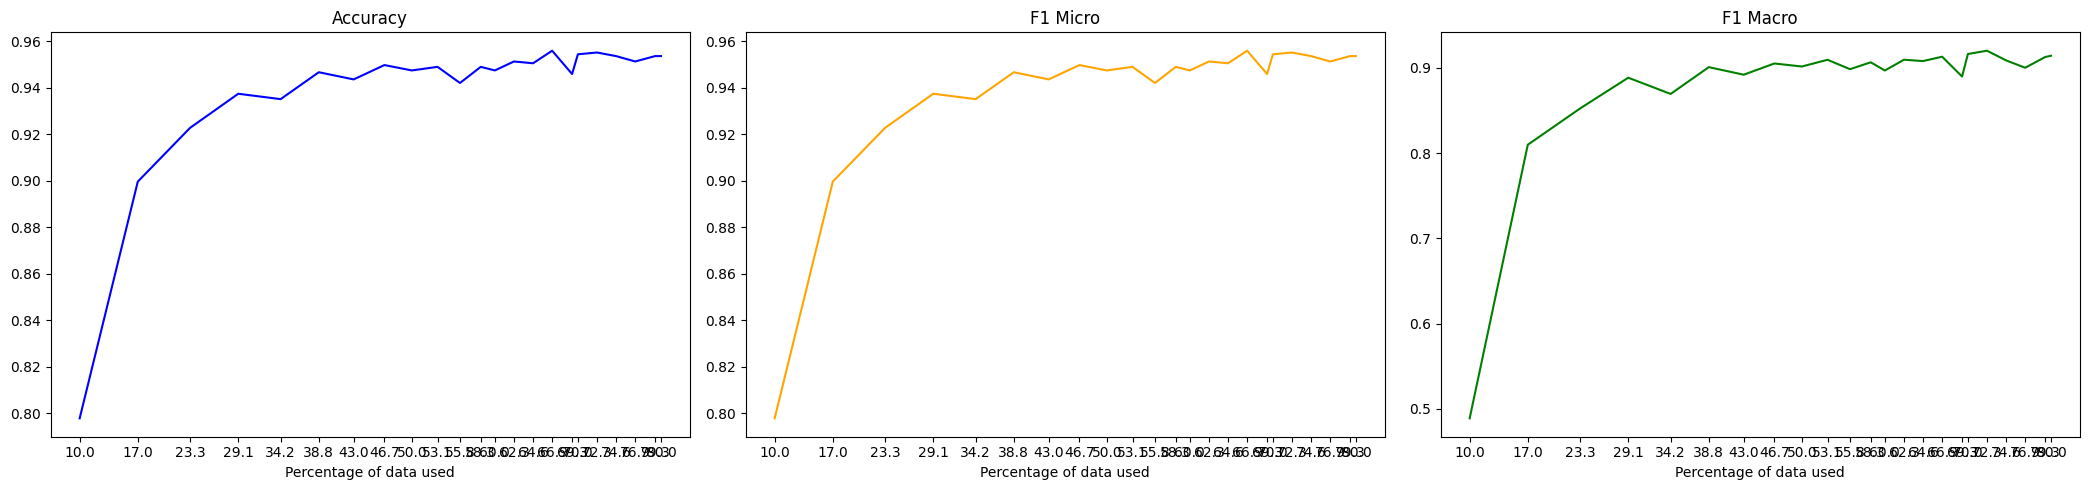

In [26]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)